# Modelarea preturilor de inchidere a actiunilor nVidia folosind un model ARIMA

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
from arima_model import (split_data
                         ,plot_pacf_acf
                         ,adfuller_and_diff
                         ,train_predict_plot)

In [ ]:
# Incarcarea bazei de date
dataset_train = pd.read_csv('NVDA.csv', index_col='Date', parse_dates=True)

In [ ]:
plt.plot(dataset_train.index, dataset_train['Close'])
plt.title('Daily Closing price for NVDA stocks')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [ ]:
plot_pacf_acf(dataset_train, 'Close')

In [ ]:
adfuller_and_diff(dataset_train, 'Close')

In [ ]:
dataset_train.head()

In [ ]:
plot_pacf_acf(dataset_train, 'Close_diff_1')

In [ ]:
train_dataset, test_dataset = split_data(dataset_train)

In [ ]:
train_predict_plot(dataset_train, train_dataset, test_dataset, 'Close', (1,1,1))

In [ ]:
train_predict_plot(dataset_train, train_dataset, test_dataset, 'Close', (3,1,3))

# Modelarea preturilor de inchidere a actiunilor nVidia folosind un model de tip Long Short-Term Memory (LTSM)

Incarcarea librariilor

In [8]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import datetime as dt
from pylab import rcParams


Incarcarea bazei de date

In [ ]:

# Incarcarea bazei de date
dataset_train = pd.read_csv('NVDA.csv', index_col='Date', parse_dates=True)


# Ne asiguram ca avem un pret de inchidere al activului financiar
assert 'Close' in dataset_train.columns, "'Close' column is missing in dataset_train"

# Scalarea datelor
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_train_scaled = scaler.fit_transform(dataset_train[['Close']])

# Convertirea datelor scalate intr-un nou DataFrame
dataset_train_scaled = pd.DataFrame(dataset_train_scaled, index=dataset_train.index, columns=['Close'])

# Verificarea noului DataFrame
print(dataset_train_scaled.head())


Crearea modelului de training

In [10]:
# Importam librariile necesare
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
import numpy as np

# Crearea modelului secvential (folosim pretul de inchidere a 20 de zile trecute pentru a prezice pretul de inchidere pentru 5 de zile viitoare)
n_future = 5
n_past = 20

X_train = []
y_train = []

for i in range(n_past, len(dataset_train_scaled) - n_future):
    X_train.append(dataset_train_scaled.iloc[i - n_past:i].values)
    y_train.append(dataset_train_scaled.iloc[i + n_future - 1].values)

X_train, y_train = np.array(X_train), np.array(y_train)


Antrenarea modelului

In [ ]:

# Definirea modelului
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, 1)))
model.add(LSTM(units=10, return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(units=1, activation='linear'))

# Compilarea modelului
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Antrenarea modelului
model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)




Stabilirea pretului viitor utilizand modelul antrenat

In [3]:
# Prezicerea pretului de inchidere viitor
future_predictions = []
current_batch = dataset_train_scaled[-n_past:].values.reshape((1, n_past, 1))

for i in range(n_future):
    future_pred = model.predict(current_batch)[0]
    future_predictions.append(future_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[future_pred]], axis=1)

# Convertim predictiile intr-un nou DataFrame
future_dates = pd.date_range(start=dataset_train.index[-1], periods=n_future + 1, inclusive='right')
PREDICTIONS_FUTURE = pd.DataFrame(scaler.inverse_transform(future_predictions), index=future_dates, columns=['Close'])

# Rescalam datele de training la valorile originale
PREDICTION_TRAIN = pd.DataFrame(scaler.inverse_transform(model.predict(X_train)), index=dataset_train.index[n_past:len(X_train) + n_past], columns=['Close'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


Calcularea diferentelor dintre setul de train si setul real

In [11]:
# Extragem pretul din setul real si il aliniem sa fie in acelasi range ca cel din setul de train
ACTUAL_TRAIN = dataset_train['Close'].iloc[n_past:len(X_train) + n_past]

# Ne asiguram ca data este aliniata coresounzator
ACTUAL_TRAIN.index = PREDICTION_TRAIN.index

# Calculam diferentele dintre pretul real si pretul prezis
DIFFERENCES_TRAIN = ACTUAL_TRAIN - PREDICTION_TRAIN['Close']

# Converitm noua variabila intr-un Data Frame nou
DIFFERENCES_TRAIN_DF = pd.DataFrame({'Pret actual': ACTUAL_TRAIN, 'Pret Train': PREDICTION_TRAIN['Close'], 'Training Price vs. Actual price': DIFFERENCES_TRAIN})

# Verificarea rezultatelor
DIFFERENCES_TRAIN_DF.head()

,Pret actual,Pret Train,Training Price vs. Actual price
Date,,,
1999-02-22,0.437500,1.241520,-0.804020
1999-02-23,0.458333,1.245624,-0.787291
1999-02-24,0.494792,1.252043,-0.757251
1999-02-25,0.479167,1.263420,-0.784253
1999-02-26,0.457031,1.273493,-0.816462


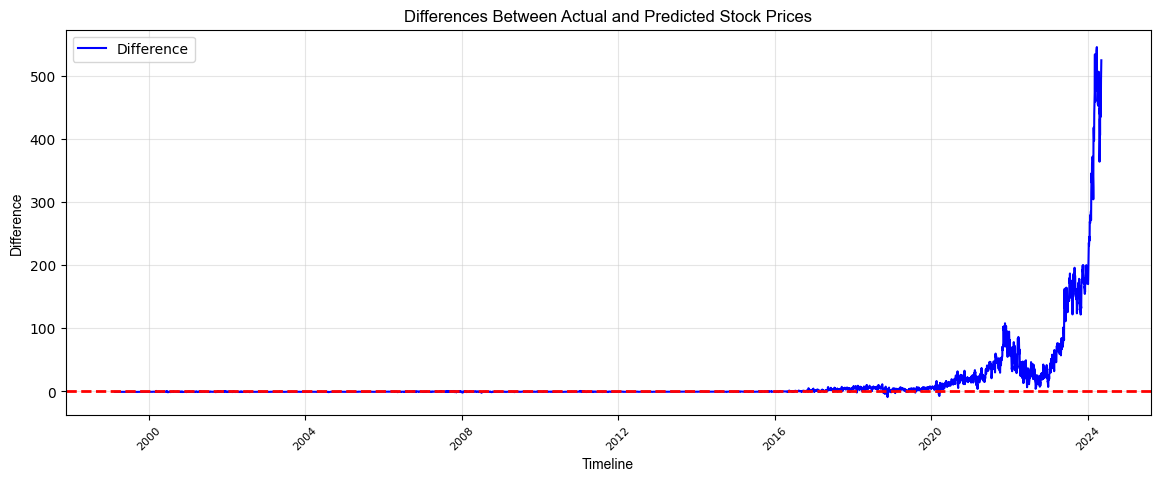

In [5]:
import matplotlib.pyplot as plt

# Createa unui nou DataFrame cu preturile actuale, preturile prezise si diferentele dintre acestea
DIFFERENCES_TRAIN_DF = pd.DataFrame({
    'Pret actual': ACTUAL_TRAIN,
    'Pret Train': PREDICTION_TRAIN['Close'],
    'Difference': DIFFERENCES_TRAIN
})


# Realizam un grafic al diferentelor
plt.figure(figsize=(14, 5))
plt.plot(DIFFERENCES_TRAIN_DF.index, DIFFERENCES_TRAIN_DF['Difference'], label='Difference', color='blue')
plt.axhline(0, color='red', linestyle='--', linewidth=2)

# Setarea parametrilor graficului
plt.title('Differences Between Actual and Predicted Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Difference', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.grid(which='major', color='#cccccc', alpha=0.5)
plt.legend()
plt.show()

Calcularea statisticilor

In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import ttest_rel

# Extragem preturile actuale si preturile prezise
actual_values = DIFFERENCES_TRAIN_DF['Pret actual']
predicted_values = DIFFERENCES_TRAIN_DF['Pret Train']

# Calculam MAE
mae = mean_absolute_error(actual_values, predicted_values)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculam MSE
mse = mean_squared_error(actual_values, predicted_values)
print(f"Mean Squared Error (MSE): {mse}")

# Calculam RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculam MAPE
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Calculam R-squared
r2 = r2_score(actual_values, predicted_values)
print(f"R-squared (R²): {r2}")

# Calculam t-test
t_stat, p_value = ttest_rel(actual_values, predicted_values)
print(f"Paired t-test: t-statistic = {t_stat}, p-value = {p_value}")


Mean Absolute Error (MAE): 14.558077680744164
Mean Squared Error (MSE): 3107.67504498375
Root Mean Squared Error (RMSE): 55.746524958814696
Mean Absolute Percentage Error (MAPE): 27.500053045538515%
R-squared (R²): 0.7940675489505874
Paired t-test: t-statistic = 20.11880979961639, p-value = 2.5567405543019905e-87


Reprezentarea grafica a rezultatelor

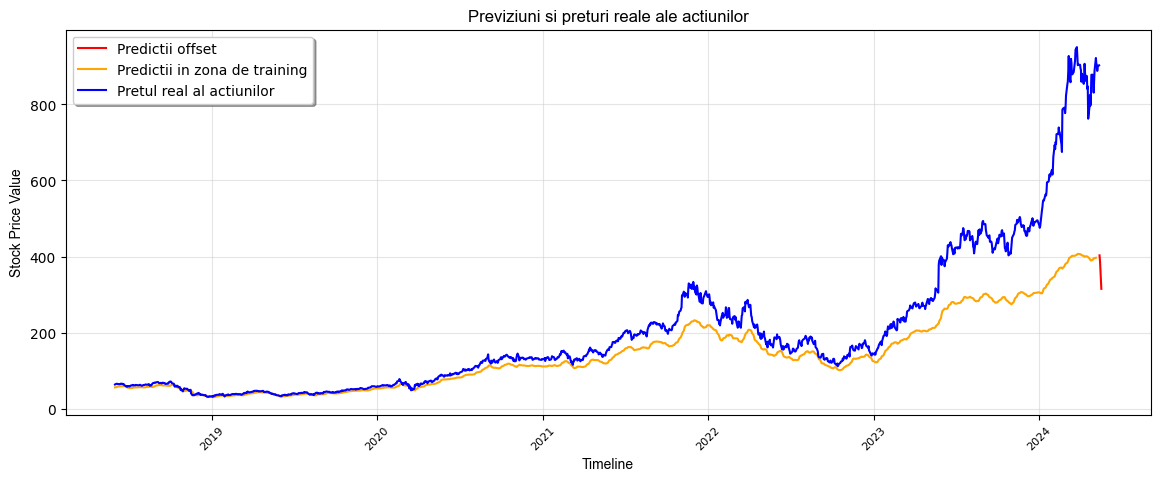

In [7]:
# Setam paramterii graficului
rcParams['figure.figsize'] = 14, 5

# Setarea unei date pentru inceputul graficului
START_DATE_FOR_PLOTTING = dt.datetime.strptime('2018-06-01', '%Y-%m-%d').date()

# Ne asiguram ca indecsii sunt de tip date
PREDICTIONS_FUTURE.index = pd.to_datetime(PREDICTIONS_FUTURE.index)
PREDICTION_TRAIN.index = pd.to_datetime(PREDICTION_TRAIN.index)
dataset_train.index = pd.to_datetime(dataset_train.index)

# Grafic
plt.figure(figsize=(14, 5))
plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Close'], color='r', label='Predictii offset')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Close'], color='orange', label='Predictii in zona de training')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Close'], color='b', label='Pretul real al actiunilor')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Previziuni si preturi reale ale actiunilor', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()
